In [1]:
#usual imports
import numpy as np
import ROOT as r
import matplotlib.pyplot as plt
from root_numpy import tree2array, testdata, list_branches
import pandas as pd
import time
import xgboost as xg
from sklearn.metrics import roc_auc_score, roc_curve

trainFrac = 0.7
validFrac = 0.1
nClasses = 10

Welcome to JupyROOT 6.12/06


/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#get trees from files, put them in data frames
procFileMap = {'ggh':'ggH.root', 'dipho':'Dipho.root', 'gjet':'GJet.root', 'qcd':'QCD.root' }
theProcs = procFileMap.keys()

trainDir = '../trainTrees'
trainFrames = {}

for proc,fn in procFileMap.iteritems():
    trainFile   = r.TFile('%s/%s'%(trainDir,fn))
    if 'ggh' in proc or 'vbf' in proc: trainTree = trainFile.Get('vbfTagDumper/trees/%s_125_13TeV_VBFDiJet'%proc)
    else: trainTree = trainFile.Get('vbfTagDumper/trees/%s_13TeV_VBFDiJet'%proc)
    trainFrames[proc] = pd.DataFrame( tree2array(trainTree) )
    trainFrames[proc]['proc'] = proc

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/root_numpy/_tree.py:385: RuntimeWarning: ignoring duplicate branch named 'nvtx'
  cache_size)


In [3]:
#create one total frame
trainList = []
for proc in theProcs:
    trainList.append(trainFrames[proc])
trainTotal = pd.concat(trainList)

In [4]:
#then filter out the events into only those with the phase space we are interested in
#trainTotal[trainTotal.diphomva>-0.4]
#print 'done dipho mva cut'
trainTotal = trainTotal[trainTotal.CMS_hgg_mass>100.]
print 'done lower mass cut'
trainTotal = trainTotal[trainTotal.CMS_hgg_mass<180.]
print 'done upper mass cut'
trainTotal = trainTotal[trainTotal.stage1cat>-1.]
print 'done first stage 1 cut'
trainTotal = trainTotal[trainTotal.stage1cat<12.]
print 'done second stage 1 cut'
trainTotal = trainTotal[trainTotal.stage1cat!=1]
print 'done third stage 1 cut'
trainTotal = trainTotal[trainTotal.stage1cat!=2]
print 'done fourth and final stage 1 cut'

done lower mass cut
done upper mass cut
done first stage 1 cut
done second stage 1 cut
done third stage 1 cut
done fourth and final stage 1 cut


In [5]:
#add diphoton pt as a column
def addPt(row):
    return row['CMS_hgg_mass']*row['diphoptom']

trainTotal['diphopt'] = trainTotal.apply(addPt, axis=1)

In [12]:
#define the different sets of variables used
diphoVars  = ['leadmva','subleadmva','leadptom','subleadptom','leadeta','subleadeta',
              'CosPhi','vtxprob','sigmarv','sigmawv']
diphoPtVar = ['diphopt']
jetVars    = ['n_rec_jets','dijet_Mjj','dijet_leadEta','dijet_subleadEta','dijet_subsubleadEta',
              #'dijet_LeadJPt','dijet_SubJPt','dijet_SubsubJPt',
              'dijet_LeadJPt','dijet_SubJPt', #forgot to add 3rd jet pT to variable list
              'dijet_leadPUMVA','dijet_subleadPUMVA','dijet_subsubleadPUMVA',
              'dijet_leadDeltaPhi','dijet_subleadDeltaPhi','dijet_subsubleadDeltaPhi',
              'dijet_leadDeltaEta','dijet_subleadDeltaEta','dijet_subsubleadDeltaEta']
#trainVars = diphoVars + jetVars
trainVars = diphoVars + jetVars + diphoPtVar
print trainVars
#trainTotal[diphoVars]
#trainTotal[trainVars]

['leadmva', 'subleadmva', 'leadptom', 'subleadptom', 'leadeta', 'subleadeta', 'CosPhi', 'vtxprob', 'sigmarv', 'sigmawv', 'n_rec_jets', 'dijet_Mjj', 'dijet_leadEta', 'dijet_subleadEta', 'dijet_subsubleadEta', 'dijet_LeadJPt', 'dijet_SubJPt', 'dijet_leadPUMVA', 'dijet_subleadPUMVA', 'dijet_subsubleadPUMVA', 'dijet_leadDeltaPhi', 'dijet_subleadDeltaPhi', 'dijet_subsubleadDeltaPhi', 'dijet_leadDeltaEta', 'dijet_subleadDeltaEta', 'dijet_subsubleadDeltaEta', 'diphopt']


In [7]:
#add column corresponding to truth bin
def truth(row):
    if not row['stage1cat']==0: return int(row['stage1cat']-2)
    else: return 0

trainTotal['truth'] = trainTotal.apply(truth,axis=1)
displayVars = diphoVars + ['truth']
#trainTotal[displayVars]

In [8]:
#add column corresponding to reco bin
def reco(row):
    if row['n_rec_jets']==0: return 1
    elif row['n_rec_jets']==1:
        if row['diphopt'] < 60: return 2
        elif row['diphopt'] < 120: return 3
        elif row['diphopt'] < 200: return 4
        else: return 5
    else:
        if row['diphopt'] < 60: return 6
        elif row['diphopt'] < 120: return 7
        elif row['diphopt'] < 200: return 8
        else: return 9


trainTotal['reco'] = trainTotal.apply(reco,axis=1)

In [9]:
#add column with full weights for testing
def fullWeight(row):
    if row['proc'] == 'dipho': return 3. * row['weight'] #only using 1/3 of the diphoton sample
    else: return row['weight']
trainTotal['fullWeight'] = trainTotal.apply(fullWeight,axis=1)

In [10]:
#add column with *normalised weights for training only*
weightFactors = [1., 0.0002994, 0.0000757, 0.0000530, 0.0000099, 0.0000029, 0.0000154, 0.0000235, 0.0000165, 0.0000104]
def normWeight(row):
    weight = row['weight']
    if row['proc'] == 'dipho': 
        weight *= 3. / weightFactors[ int(row['truth']) ] #only using 1/3 of the diphoton sample
    elif row['proc'] == 'qcd': 
        weight *= 0.04 / weightFactors[ int(row['truth']) ] #reduce because too large by default
    else: 
        weight *= 1. / weightFactors[ int(row['truth']) ] #otherwise just reweight by xs
    #now account for the resolution
    if row['sigmarv']>0. and row['sigmawv']>0.:
        weight *= ( (row['vtxprob']/row['sigmarv']) + ((1.-row['vtxprob'])/row['sigmawv']) )
    weight = abs(weight)
    return weight
trainTotal['normedWeight'] = trainTotal.apply(normWeight,axis=1)

#elif row['truth'] == 1: return 5. * row['weight'] / weightFactors[ int(row['truth']) ] #optional ad-hoc factor

In [13]:
#setup the various datasets
allX = trainTotal[trainVars].values #BDT input variables
allY = trainTotal['truth'].values #truth/target values (i.e. the gen-level Stage 1 bins)
allFW = trainTotal['fullWeight'].values #weights corresponding to number of events
allNW = trainTotal['normedWeight'].values #normalised weights for training - can be played with
allR = trainTotal['reco'].values
allM = trainTotal['CMS_hgg_mass'].values
shuffle = np.random.permutation(allX.shape[0])
allX = allX[shuffle]
allY = allY[shuffle]
allFW = allFW[shuffle]
allNW = allNW[shuffle]
allR = allR[shuffle]
allM = allM[shuffle]
trainLimit = int(allX.shape[0]*trainFrac)
validLimit = int(allX.shape[0]*(trainFrac+validFrac))
trainX, validX, testX = np.split( allX, [trainLimit,validLimit] )
trainY, validY, testY = np.split( allY, [trainLimit,validLimit] )
trainFW, validFW, testFW = np.split( allFW, [trainLimit,validLimit] )
trainNW, validNW, testNW = np.split( allNW, [trainLimit,validLimit] )
trainR, validR, testR = np.split( allR, [trainLimit,validLimit] )
trainM, validM, testM = np.split( allM, [trainLimit,validLimit] )

In [14]:
#one attempt at building classifier
training = xg.DMatrix(trainX, label=trainY, weight=trainNW, feature_names=trainVars)
#training = xg.DMatrix(trainX, label=trainY, weight=trainFW)
testing = xg.DMatrix(testX, label=testY, weight=testFW, feature_names=trainVars)
param = {}
param['objective'] = 'multi:softprob'
param['num_class'] = nClasses
classifier = xg.train(param, training)

[13:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[13:06:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[13:06:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[13:07:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[13:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[13:07:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[13:08:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[13:08:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[13:08:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned node

In [15]:
#get predicted values
predProb = classifier.predict(testing).reshape(testY.shape[0],nClasses)
#print predProb
#print predProb[:,1:]
pred = np.argmax(predProb[:,1:], axis=1) + 1 #don't want to class as background
print testY
print pred

[0 0 0 ..., 0 0 0]
[2 3 1 ..., 2 1 3]


In [16]:
#setup 2D hists
truthHist = r.TH1F('truthHist','truthHist',nClasses,-0.5,nClasses-0.5)
predHist  = r.TH1F('predHist','predHist',nClasses,-0.5,nClasses-0.5)
rightHist = r.TH1F('rightHist','rightHist',nClasses,-0.5,nClasses-0.5)
wrongHist = r.TH1F('wrongHist','wrongHist',nClasses,-0.5,nClasses-0.5)
for true,guess,w in zip(testY,pred,testFW):
    truthHist.Fill(true,w)
    predHist.Fill(guess,w)
    if true==guess: rightHist.Fill(true,w)
    else: wrongHist.Fill(true,w)
firstBinVal = -1.
for iBin in range(1,truthHist.GetNbinsX()+1):
    if iBin==1: firstBinVal = truthHist.GetBinContent(iBin)
    ratio = float(truthHist.GetBinContent(iBin)) / firstBinVal
    print 'ratio for bin %g is %1.7f'%(iBin,ratio)
wrongHist.Add(rightHist)
rightHist.Divide(wrongHist)
effHist = r.TH1F
r.gStyle.SetOptStat(0)
canv = r.TCanvas()
canv.cd()
truthHist.GetYaxis().SetRangeUser(0.,6.)
truthHist.Draw('hist')
canv.Print('truthHist.pdf')
predHist.GetYaxis().SetRangeUser(0.,6.)
predHist.Draw('hist')
canv.Print('predHist.pdf')
rightHist.GetYaxis().SetRangeUser(0.,1.)
rightHist.Draw('hist')
canv.Print('efficiencyHist.pdf')

ratio for bin 1 is 1.0000000
ratio for bin 2 is 0.0002838
ratio for bin 3 is 0.0000689
ratio for bin 4 is 0.0000505
ratio for bin 5 is 0.0000088
ratio for bin 6 is 0.0000025
ratio for bin 7 is 0.0000130
ratio for bin 8 is 0.0000229
ratio for bin 9 is 0.0000146
ratio for bin 10 is 0.0000106


Info in <TCanvas::Print>: pdf file truthHist.pdf has been created
Info in <TCanvas::Print>: pdf file predHist.pdf has been created
Info in <TCanvas::Print>: pdf file efficiencyHist.pdf has been created


In [17]:
#generate weights for the 2D hists    
sumwProcCatMapReco = {}
sumwProcCatMapPred = {}
sumwProcMap = {}
for iProc in range(1, nClasses):
    sumwProcMap[iProc] = np.sum(testFW*(testY==iProc))
    for jProc in range(nClasses):
        sumwProcCatMapPred[(iProc,jProc)] = np.sum(testFW*(testY==iProc)*(pred==jProc))
        sumwProcCatMapReco[(iProc,jProc)] = np.sum(testFW*(testY==iProc)*(testR==jProc))
sumwCatMapReco = {}
sumwCatMapPred = {}
for iProc in range(1, nClasses):
    #sumwCatMapPred[iProc] = np.sum(testFW*(pred==iProc))
    #sumwCatMapReco[iProc] = np.sum(testFW*(testR==iProc)
    sumwCatMapPred[iProc] = np.sum(testFW*(pred==iProc)*(testY!=0)) #don't count bkg here
    sumwCatMapReco[iProc] = np.sum(testFW*(testR==iProc)*(testY!=0))

In [18]:
#fill the 2D hists
nBinsX=nClasses
nBinsY=nClasses
procHistReco = r.TH2F('procHistReco','procHistReco', nBinsX, -0.5, nBinsX-0.5, nBinsY, -0.5, nBinsY-0.5)
procHistReco.SetTitle('')
procHistPred = r.TH2F('procHistPred','procHistPred', nBinsX, -0.5, nBinsX-0.5, nBinsY, -0.5, nBinsY-0.5)
procHistPred.SetTitle('')
catHistReco  = r.TH2F('catHistReco','catHistReco', nBinsX, -0.5, nBinsX-0.5, nBinsY, -0.5, nBinsY-0.5)
catHistReco.SetTitle('')
catHistPred  = r.TH2F('catHistPred','catHistPred', nBinsX, -0.5, nBinsX-0.5, nBinsY, -0.5, nBinsY-0.5)
catHistPred.SetTitle('')
for iProc in range(1, nClasses):
    for jProc in range(1, nClasses):
        procWeightReco = 100. * sumwProcCatMapReco[(iProc,jProc)] / sumwProcMap[iProc]
        procWeightPred = 100. * sumwProcCatMapPred[(iProc,jProc)] / sumwProcMap[iProc]
        catWeightReco  = 100. * sumwProcCatMapReco[(iProc,jProc)] / sumwCatMapReco[jProc]
        catWeightPred  = 100. * sumwProcCatMapPred[(iProc,jProc)] / sumwCatMapPred[jProc]
        
        procHistReco.Fill(iProc, jProc, procWeightReco)
        procHistPred.Fill(iProc, jProc, procWeightPred)
        catHistReco.Fill(iProc, jProc, catWeightReco)
        catHistPred.Fill(iProc, jProc, catWeightPred)

In [19]:
#draw the 2D hists
def prettyHist(hist):
    hist.SetStats(0)
    hist.GetXaxis().SetTitle('Process')
    hist.GetXaxis().SetTickLength(0.)
    hist.GetYaxis().SetTitle('Category')
    hist.GetYaxis().SetTitleOffset(1.5)
    hist.GetYaxis().SetTickLength(0.)
    hist.SetMinimum(-0.00001)
    hist.SetMaximum(100.)
    
canv = r.TCanvas()
r.gStyle.SetPaintTextFormat('2.0f')
prettyHist(procHistReco)
procHistReco.Draw('colz,text')
canv.Print('procHistReco.pdf')
prettyHist(catHistReco)
catHistReco.Draw('colz,text')
canv.Print('catHistReco.pdf')
prettyHist(procHistPred)
procHistPred.Draw('colz,text')
canv.Print('procHistPred.pdf')
prettyHist(catHistPred)
catHistPred.Draw('colz,text')
canv.Print('catHistPred.pdf')

Info in <TCanvas::Print>: pdf file procHistReco.pdf has been created
Info in <TCanvas::Print>: pdf file catHistReco.pdf has been created
Info in <TCanvas::Print>: pdf file procHistPred.pdf has been created
Info in <TCanvas::Print>: pdf file catHistPred.pdf has been created


In [20]:
#draw the bkg-prob distribution for each category
bkgHists = {}
sigHists = {}
bkgProb = predProb[:,0]*(testY==0)
for iProc in range(1, nClasses):
    sigProb = predProb[:,0]*(testY==iProc) #could do this for inclusive signal? Or add other signal to background...
    bkgHists[iProc] = r.TH1F('bkgProb_%s'%iProc, 'bkgProb_%s'%iProc, 50, 0., 1.)
    sigHists[iProc] = r.TH1F('sigProb_%s'%iProc, 'sigProb_%s'%iProc, 50, 0., 1.)
    for bkg,sig,w in zip(bkgProb,sigProb,testFW):
        if bkg!=0: bkgHists[iProc].Fill(1.-bkg,w)
        if sig!=0: sigHists[iProc].Fill(1.-sig,w)
canv = r.TCanvas()
for iProc in range(1, nClasses):
    bkgInt = bkgHists[iProc].Integral()
    bkgHists[iProc].Scale(1./bkgInt)
    bkgHists[iProc].SetLineColor(r.kBlack)
    sigInt = sigHists[iProc].Integral()
    sigHists[iProc].Scale(1./sigInt)
    sigHists[iProc].SetLineColor(r.kGreen+1)
    sigHists[iProc].Draw('hist')
    bkgHists[iProc].Draw('hist,same')
    canv.Print('bkgProb_%s.pdf'%iProc)

Info in <TCanvas::Print>: pdf file bkgProb_1.pdf has been created
Info in <TCanvas::Print>: pdf file bkgProb_2.pdf has been created
Info in <TCanvas::Print>: pdf file bkgProb_3.pdf has been created
Info in <TCanvas::Print>: pdf file bkgProb_4.pdf has been created
Info in <TCanvas::Print>: pdf file bkgProb_5.pdf has been created
Info in <TCanvas::Print>: pdf file bkgProb_6.pdf has been created
Info in <TCanvas::Print>: pdf file bkgProb_7.pdf has been created
Info in <TCanvas::Print>: pdf file bkgProb_8.pdf has been created
Info in <TCanvas::Print>: pdf file bkgProb_9.pdf has been created


In [21]:
#calculate (very) naive significance
lumi = 77.
for iProc in range(1, nClasses):
    sigReco = lumi * sumwProcCatMapReco[(iProc,iProc)]
    sigPred = lumi * sumwProcCatMapPred[(iProc,iProc)]
    totReco = lumi * sumwCatMapReco[iProc]
    totPred = lumi * sumwCatMapPred[iProc]
    bkgReco = lumi * np.sum(testFW * (testY==0) * (pred==iProc) * (testM>123.) * (testM<127.) * (bkgProb<0.08))
    bkgPred = lumi * np.sum(testFW * (testY==0) * (pred==iProc) * (testM>123.) * (testM<127.) * (bkgProb<0.08))
    valReco = sigReco / np.sqrt(totReco+bkgReco)
    valPred = sigPred / np.sqrt(totPred+bkgPred)
    print 'for class %g the S and B counts are:'%iProc
    print 'Reco: %1.3f and %1.3f,   BDT %1.3f and %1.3f'%(sigReco, totReco+bkgReco, sigPred, totPred+bkgPred)
    print 'corresponding to naive significance of:'
    print 'Reco: %1.3f,   BDT %1.3f \n'%(valReco, valPred)

for class 1 the S and B counts are:
Reco: 459.609 and 6159.931,   BDT 381.259 and 6041.355
corresponding to naive significance of:
Reco: 5.856,   BDT 4.905 

for class 2 the S and B counts are:
Reco: 80.015 and 12878.683,   BDT 96.088 and 12953.235
corresponding to naive significance of:
Reco: 0.705,   BDT 0.844 

for class 3 the S and B counts are:
Reco: 69.134 and 5317.241,   BDT 75.898 and 5328.607
corresponding to naive significance of:
Reco: 0.948,   BDT 1.040 

for class 4 the S and B counts are:
Reco: 12.884 and 459.407,   BDT 14.074 and 461.466
corresponding to naive significance of:
Reco: 0.601,   BDT 0.655 

for class 5 the S and B counts are:
Reco: 3.789 and 48.832,   BDT 4.239 and 50.327
corresponding to naive significance of:
Reco: 0.542,   BDT 0.597 

for class 6 the S and B counts are:
Reco: 14.520 and 11675.203,   BDT 17.834 and 11698.696
corresponding to naive significance of:
Reco: 0.134,   BDT 0.165 

for class 7 the S and B counts are:
Reco: 29.313 and 3465.064,   B

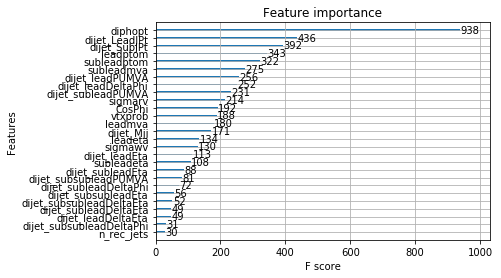

In [22]:
# get feature importances
xg.plot_importance(classifier)
plt.show()

In [23]:
#define rms function
def getWidth(array):
    sumW = np.sum(array)
    mean = np.sum(array*testM)/ sumW
    diff = testM - mean
    diffSq = diff*diff
    sumDiffSq = np.sum(diffSq*array) / sumW
    width = np.sqrt(sumDiffSq)
    return width

In [24]:
#define approximate mean significance
def getAMS(s, b, breg=1.):
    b = b + breg
    val = 0.
    if b > 0.:
        val = (s + b)*np.log(1. + (s/b))
        val = 2*(val - s)
        val = np.sqrt(val)
    return val

In [25]:
#going to try two different significance estimates - hopefully they agree well.. 
#first is to use only numpy, i.e. no ROOT, so a bit cruder bc no bkg fit and rms instead of effSigma
lumi = 77.
theProbs = 1. - predProb[:,0]

#first do one category
for iProc in range(1, nClasses):
    bestCut = -1.
    bestSignif = -1.
    bestSig = -1.
    bestBkg = -1.
    #for cut in np.random.rand(100,1):
    for cut in np.arange(0.9,1.0,0.0005):
        sigArray = testFW * (testY==iProc) * (pred==iProc) * (theProbs>cut)
        sigPred = lumi * 0.68 * np.sum( sigArray )
        #sigRMS = getWidth(sigArray)
        sigRMS = 0.67 * getWidth(sigArray) #ad hoc because rms seems to be an overestimate
        #if cut < 0.9501 and cut > 0.9495: print 'sig RMS in proc %g is %1.3f'%(iProc,sigRMS)
        totArray = testFW * (testY!=0) * (pred==iProc) * (theProbs>cut)
        totPred = lumi * 0.68 * np.sum( totArray )
        bkgArray = testFW * (testY==0) * (pred==iProc) * (testM>(125.-sigRMS)) * (testM<(125.+sigRMS)) * (theProbs>cut)
        bkgPred = lumi * np.sum(bkgArray)
        fullBkg = bkgPred + totPred - sigPred
        valPred = getAMS(sigPred, fullBkg)
        #print 'cut is %1.3f'%cut
        #print 'rms is %1.2f'%sigRMS
        #print 'S, B are %1.2f, %1.2f'%(sigPred,fullBkg)
        #print 'signif is %1.2f'%valPred
        if valPred > bestSignif: 
            bestCut = cut
            bestSignif = valPred
            bestSig = sigPred
            bestBkg = fullBkg
    print 'optimal one-category signifiance for proc %s:'%(iProc)
    print 'cut = %1.3f, S = %1.2f, B = %1.2f, signif = %1.2f'%(bestCut, bestSig, bestBkg, bestSignif)
    print

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in greater
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in less


optimal one-category signifiance for proc 1:
cut = 0.943, S = 178.29, B = 3791.41, signif = 2.87

optimal one-category signifiance for proc 2:
cut = 0.979, S = 21.73, B = 611.46, signif = 0.87

optimal one-category signifiance for proc 3:
cut = 0.976, S = 43.15, B = 2418.52, signif = 0.87

optimal one-category signifiance for proc 4:
cut = 0.984, S = 8.87, B = 246.63, signif = 0.56



/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in sqrt


optimal one-category signifiance for proc 5:
cut = 0.988, S = 2.50, B = 24.21, signif = 0.49

optimal one-category signifiance for proc 6:
cut = 0.973, S = 11.18, B = 5935.30, signif = 0.15

optimal one-category signifiance for proc 7:
cut = 0.988, S = 9.47, B = 263.80, signif = 0.58

optimal one-category signifiance for proc 8:
cut = 0.987, S = 11.49, B = 792.24, signif = 0.41

optimal one-category signifiance for proc 9:
cut = 0.993, S = 8.12, B = 19.42, signif = 1.69



In [ ]:
#now try two categories
for iProc in range(1, nClasses):
    bestLoCut = -1.
    bestHiCut = -1.
    bestSignif = -1.
    for cut1 in np.random.rand(50,1):
        for cut2 in np.random.rand(50,1):
            loCut = min(cut1, cut2)
            hiCut = max(cut1, cut2)
            #get significance of first (purest) cat
            sigArray = testFW * (testY==iProc) * (pred==iProc) * (theProbs>hiCut)
            sigPred = lumi * 0.68 * np.sum( sigArray )
            sigRMS = getWidth(sigArray)
            totArray = testFW * (testY!=0) * (pred==iProc) * (theProbs>hiCut)
            totPred = lumi * 0.68 * np.sum( totArray )
            bkgArray = testFW * (testY==0) * (pred==iProc) * (testM>(125.-sigRMS)) * (testM<(125.+sigRMS)) * (theProbs>hiCut)
            bkgPred = lumi * np.sum(bkgArray)
            fullBkg = bkgPred + totPred - sigPred
            valPred_0 = getAMS(sigPred, fullBkg)
            #get significance of second (purest) cat
            sigArray = testFW * (testY==iProc) * (pred==iProc) * (theProbs>loCut) * (theProbs<hiCut)
            sigPred = lumi * 0.68 * np.sum( sigArray )
            sigRMS = getWidth(sigArray)
            totArray = testFW * (testY!=0) * (pred==iProc) * (theProbs>loCut) * (theProbs<hiCut)
            totPred = lumi * 0.68 * np.sum( totArray )
            bkgArray = testFW * (testY==0) * (pred==iProc) * (testM>(125.-sigRMS)) * (testM<(125.+sigRMS)) * (theProbs>loCut) * (theProbs<hiCut)
            bkgPred = lumi * np.sum(bkgArray)
            fullBkg = bkgPred + totPred - sigPred
            valPred_1 = np.getAMS(sigPred, fullBkg)
            valPred = np.sqrt( valPred_0*valPred_0 + valPred_1*valPred_1)
            if valPred > bestSignif: 
                bestLoCut = loCut
                bestHiCut = hiCut
                bestSignif = valPred
    print 'optimal two-category signifiance for proc %s:'%(iProc)
    print 'cutLow = %1.2f, cutHigh = %1.2f, signif = %1.2f'%(bestLoCut, bestHiCut, bestSignif)
    print

In [26]:
#now move on to the more "traditional method", which uses a fit to bkg distribution and full sigmaEff calc
#set up 2D hists in diphoMass, bkgProb
diagSigHists = {}
fullSigHists = {}
bkgOnlyHists = {}
nBins = 100
for iProc in range(1, nClasses):
    diagSigHists[iProc] = r.TH2F('diagSigHist_%g'%iProc, 'diagSigHist_%g'%iProc, 10*nBins, 0., 1., nBins, 100., 180.)
    fullSigHists[iProc] = r.TH2F('fullSigHist_%g'%iProc, 'fullSigHist_%g'%iProc, 10*nBins, 0., 1., nBins, 100., 180.)
    bkgOnlyHists[iProc] = r.TH2F('bkgOnlyHist_%g'%iProc, 'bkgOnlyHist_%g'%iProc, 10*nBins, 0., 1., nBins, 100., 180.)
    diagSigW = testFW * (testY==iProc) * (pred==iProc)
    fullSigW = testFW * (testY!=0) * (pred==iProc)
    bkgOnlyW = testFW * (testY==0) * (pred==iProc)
    for mass,prob,diagW,fullW,bkgW in zip(testM,theProbs,diagSigW,fullSigW,bkgOnlyW):
        diagSigHists[iProc].Fill(prob, mass, diagW)
        fullSigHists[iProc].Fill(prob, mass, fullW)
        bkgOnlyHists[iProc].Fill(prob, mass, bkgW)

In [27]:
#one-category optimisation
from diphoHelpers import evalSignif
for iProc in range(1, nClasses):
    bestCut = -1.
    bestSignif = -1.
    for cut in np.arange(0.9,1.0,0.001):
        #print 'checking cut of %1.3f'%cut
        signif = evalSignif( diagSigHists, fullSigHists, bkgOnlyHists, iProc, int(10*nBins*cut), 10*nBins, True )
        #print 'its signif is %1.3f'%signif
        if signif > bestSignif:
            bestCut = cut
            bestSignif = signif
    print 'optimal one-category signifiance for proc %s:'%(iProc)
    print 'cut = %1.3f, signif = %1.2f'%(bestCut, bestSignif)
    print

ImportError: No module named diphoHelpers

In [ ]:
#check the background distributions look sensible
checkHist = bkgOnlyHists[1].ProjectionY('tempProj', 900, 1000)
#checkHist = bkgOnlyHists[1]
canv = r.TCanvas()
checkHist.Draw('hist')
#checkHist.Draw('colz')
canv.Print('checkHist.pdf')